In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler # Used for scaling of data
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K

Using TensorFlow backend.


In [2]:
# Read in train data
train = pd.read_csv('../HousePrices/train.csv', index_col=0)
val = pd.read_csv('../HousePrices/val.csv', index_col=0)

Outliers
In this small part we will isolate the outliers with an IsolationForest (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html). 

In [3]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

/opt/conda/envs/tf2/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/opt/conda/envs/tf2/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/conda/envs/tf2/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Number of Outliers: 117
Number of rows without outliers: 1051


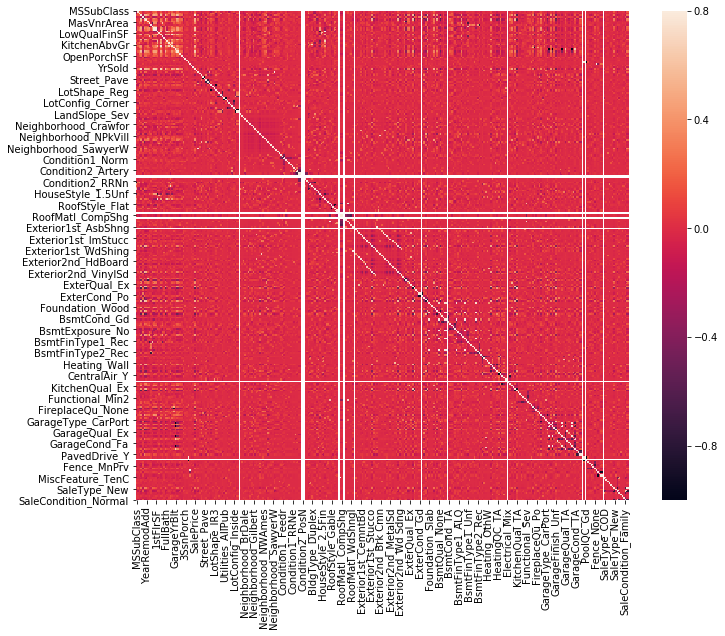

In [4]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

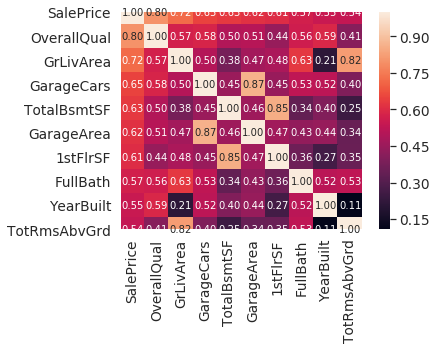

In [5]:
import numpy as np
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- GarageCars and GarageArea are two important features but we drop GarageArea since it is more or less the same information as GarageCars
- TotalBsmtSF and 1stFlrSF are also more or less the same so we drop 1StFlrSF
- TotRmsAbvGrd and GrLivArea are also strongly correlated to let's drop TotRmsAbvGrd

In [6]:
train['Surface'] = train['1stFlrSF']+train['2ndFlrSF']+train['TotalBsmtSF']

In [7]:
val['Surface'] = val['1stFlrSF']+val['2ndFlrSF']+val['TotalBsmtSF']

In [8]:
scale = StandardScaler()
X_train = train[['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt', 'LotArea','Surface', 'BsmtUnfSF']]
X_train = scale.fit_transform(X_train)

/opt/conda/envs/tf2/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/tf2/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
scale = StandardScaler()
X_val = val[['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt', 'LotArea','Surface', 'BsmtUnfSF']]
X_val = scale.fit_transform(X_val)

/opt/conda/envs/tf2/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/tf2/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [10]:
# Y is just the 'SalePrice' column
y_train = train['SalePrice'].values
y_val = val['SalePrice'].values

In [11]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import SGD, Adadelta, Adam

seed = 7
np.random.seed(seed)

# Model
model = Sequential()
model.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_absolute_error', optimizer=Adadelta())
# model.compile(loss='mean_absolute_error', optimizer=SGD(lr=0.001))
# model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))

history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=150, batch_size=10)

Train on 1051 samples, validate on 292 samples
Epoch 1/150
1051/1051 [==============================] - 1s 485us/step - loss: 181080.8108 - val_loss: 178839.8106
Epoch 2/150
1051/1051 [==============================] - 0s 318us/step - loss: 181080.8104 - val_loss: 178839.8106
Epoch 3/150
1051/1051 [==============================] - 0s 364us/step - loss: 181080.8107 - val_loss: 178839.8106
Epoch 4/150
1051/1051 [==============================] - 0s 355us/step - loss: 181080.8105 - val_loss: 178839.8106
Epoch 5/150
1051/1051 [==============================] - 0s 357us/step - loss: 181080.8102 - val_loss: 178839.8106
Epoch 6/150
1051/1051 [==============================] - 0s 367us/step - loss: 181080.8105 - val_loss: 178839.8106
Epoch 7/150
1051/1051 [==============================] - 0s 340us/step - loss: 181080.8105 - val_loss: 178839.8105
Epoch 8/150
1051/1051 [==============================] - 0s 318us/step - loss: 181080.8105 - val_loss: 178839.8105
Epoch 9/150
1051/1051 [==========

1051/1051 [==============================] - 0s 331us/step - loss: 181079.6248 - val_loss: 178838.4961
Epoch 72/150
1051/1051 [==============================] - 0s 327us/step - loss: 181079.3294 - val_loss: 178838.1523
Epoch 73/150
1051/1051 [==============================] - 0s 323us/step - loss: 181078.9126 - val_loss: 178837.6452
Epoch 74/150
1051/1051 [==============================] - 0s 336us/step - loss: 181078.2829 - val_loss: 178836.8632
Epoch 75/150
1051/1051 [==============================] - 0s 324us/step - loss: 181077.2706 - val_loss: 178835.5567
Epoch 76/150
1051/1051 [==============================] - 0s 331us/step - loss: 181075.4852 - val_loss: 178833.1243
Epoch 77/150
1051/1051 [==============================] - 0s 323us/step - loss: 181071.8484 - val_loss: 178827.7366
Epoch 78/150
1051/1051 [==============================] - 0s 323us/step - loss: 181062.4280 - val_loss: 178811.4297
Epoch 79/150
1051/1051 [==============================] - 0s 325us/step - loss: 18102

1051/1051 [==============================] - 0s 334us/step - loss: 15669.2826 - val_loss: 20975.1178
Epoch 143/150
1051/1051 [==============================] - 0s 357us/step - loss: 15669.2114 - val_loss: 20976.2794
Epoch 144/150
1051/1051 [==============================] - 0s 355us/step - loss: 15669.0556 - val_loss: 20975.8232
Epoch 145/150
1051/1051 [==============================] - 0s 337us/step - loss: 15668.8055 - val_loss: 20976.2218
Epoch 146/150
1051/1051 [==============================] - 0s 325us/step - loss: 15668.6820 - val_loss: 20976.5735
Epoch 147/150
1051/1051 [==============================] - 0s 331us/step - loss: 15668.5214 - val_loss: 20977.1550
Epoch 148/150
1051/1051 [==============================] - 0s 357us/step - loss: 15668.3687 - val_loss: 20975.8016
Epoch 149/150
1051/1051 [==============================] - 0s 338us/step - loss: 15668.0925 - val_loss: 20976.2883
Epoch 150/150
1051/1051 [==============================] - 0s 353us/step - loss: 15667.9820 - 

In [12]:
# Evaluation on the test set created by train_test_split
model.evaluate(X_train, y_train)

1051/1051 [==============================] - 0s 66us/step


15667.194510622325

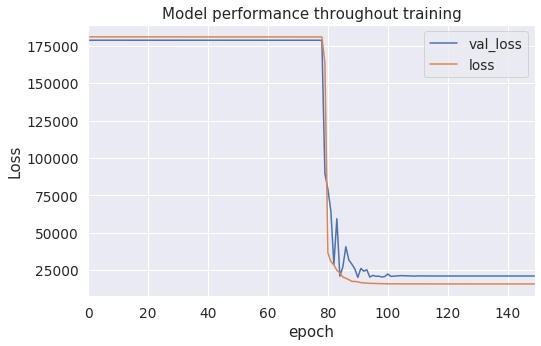

In [13]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
y_val_predict = model.predict(X_val)
y_val_predict

array([[147490.84 ],
       [318981.97 ],
       [121520.195],
       [155688.9  ],
       [302092.2  ],
       [104871.06 ],
       [195025.38 ],
       [154456.52 ],
       [104870.19 ],
       [143002.39 ],
       [142423.58 ],
       [131242.23 ],
       [119151.48 ],
       [204068.58 ],
       [180543.81 ],
       [133428.48 ],
       [201146.52 ],
       [135687.56 ],
       [123189.18 ],
       [221955.86 ],
       [176057.61 ],
       [218746.9  ],
       [179329.19 ],
       [124720.5  ],
       [201202.02 ],
       [163538.62 ],
       [193232.19 ],
       [127497.23 ],
       [178382.55 ],
       [186919.69 ],
       [118600.04 ],
       [258771.77 ],
       [206847.08 ],
       [116333.11 ],
       [253112.6  ],
       [157059.16 ],
       [159292.7  ],
       [212002.05 ],
       [324858.34 ],
       [119434.195],
       [123831.9  ],
       [234797.64 ],
       [138271.12 ],
       [288919.2  ],
       [145230.39 ],
       [153126.83 ],
       [137209.33 ],
       [13567

In [15]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_val, y_val_predict)

20975.627381207192

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
root_mean_squared_error = sqrt(mean_squared_error(y_val, y_val_predict))
print(root_mean_squared_error)

33277.8246866893


In [17]:
test = pd.read_csv('../HousePrices/test.csv', header=0)
test = test.fillna(0)

In [18]:
test['Surface'] = test['1stFlrSF']+test['2ndFlrSF']+test['TotalBsmtSF']

In [19]:
id_col = test['Id'].values.tolist()
scale = StandardScaler()
X_test = test[['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt', 'LotArea','Surface', 'BsmtUnfSF']]
X_test = scale.fit_transform(X_test)

/opt/conda/envs/tf2/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/tf2/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [20]:
prediction = model.predict(X_test)

In [21]:
submission = pd.DataFrame()
submission['Id'] = id_col
submission['SalePrice'] = prediction
submission.to_csv('prediction_keras_10features.csv', index=False)

In [22]:
submission[660:]

,Id,SalePrice
660,2121,98765.710938
661,2122,106720.781250
662,2123,103384.250000
663,2124,185175.484375
664,2125,144050.640625
...,...,...
1454,2915,104743.437500
1455,2916,110957.406250
1456,2917,176635.609375
1457,2918,132339.671875


# Score Kaggle
<center> Optimizer Adam: </center>  
Dense 200, 100, 50, 25, 1 : 0.17758  
<center> Optimizer Adadelta: </center>  
Dense 200, 100, 50, 25, 1 : 0.17197,  
Dense 8, 8, 8, 8, 1 : 0.18180,
Dense 8, 16, 32, 8, 1 : 0.18116